In [ ]:
# Internal modules
import os
import joblib
from pathlib import Path

# External modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# User modules
import src.utils.constantes as cst
import src.utils.summary as summary
import src.utils.auxiliary as auxiliary
from src.processing import dataloader
from src.processing import filtering
import src.models.scorer as scorer
import src.models.models as models
import src.models.display_results as display

%load_ext autoreload
%autoreload 2
# Paths
BASE_DIR = Path("./")
OUTPUT_DIR = BASE_DIR / "results/"
DATA_DIR = BASE_DIR / "data/"
#
results = Path("results/timepoint/")
results.mkdir(parents=True, exist_ok=True)
#
time_tt_dir = results / "time_on_time"
time_tt_dir.mkdir(parents=True, exist_ok=True)

### Dataset options

In [2]:
# Conditions
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
# Filter dataset
REMOVE_NONE = True
REPLACE_ABERRANT = -1

# Sample, feature, target columns
SAMPLE = ["FileName"]
REMOVE_SAMPLE = None
FEATURES = {"fiber-dist-shape": cst.x_fiber_columns}
TARGETS = [dataloader.enrich_2_cmask]
TARGETS_COLNAMES = [target_col(return_key=True) for target_col in TARGETS]

### Model options

In [3]:
SCORING = {
    **scorer.accuracy_score(wrap_scorer=True),
    **scorer.balanced_accuracy_score(wrap_scorer=True),
    **scorer.precision_score(wrap_scorer=True),
    **scorer.recall_score(wrap_scorer=True),
    **scorer.roc_auc_score(wrap_scorer=True),
    **scorer.matthews_corrcoef(wrap_scorer=True),
    **scorer.f1_score(wrap_scorer=True),
}
SCORING_base = {
    **scorer.accuracy_score(wrap_scorer=False),
    **scorer.balanced_accuracy_score(wrap_scorer=False),
    **scorer.precision_score(wrap_scorer=False),
    **scorer.recall_score(wrap_scorer=False),
    **scorer.roc_auc_score(wrap_scorer=False),
    **scorer.matthews_corrcoef(wrap_scorer=False),
    **scorer.f1_score(wrap_scorer=False),
}

# Generic attributes
SEED = 42
TEST_SIZE = 0.3

## Process
SAMPLE_GROUP = None if SAMPLE == [] else SAMPLE

In [4]:
timepoint_dataset = "data/output.csv.gz"  # "data/WT_DAYS.csv"
dataset_days = dataloader.Loader(
    filepath=timepoint_dataset, sep=","
)
dataset_days.data

TimeCondition                                           FileName  \
0                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
1                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
2                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
3                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
4                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
...               ...                                                ...   
1961203            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961204            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961205            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961206            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961207            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   

        Condition     X      Y  Coherency100     Energy100  MeanInt100  \
0              WT  8386     27      0.000898  1.226000e-08         0.0   
1              WT  8426     27      0.001000  1.802000e-08         0.0   
2              WT  8466     27      0.002000  2.564000e-08         0.0   
3              WT  8506     27      0.003000  3.523000e-08         0.0   
4              WT  8546     27      0.004000  4.670000e-08         0.0   
...           ...   ...    ...           ...           ...         ...   
1961203        WT  7465  17072      0.000080  1.890000e-06         NaN   
1961204        WT  7505  17072      0.000042  1.014000e-06         NaN   
1961205        WT  7545  17072      0.000022  5.383000e-07         NaN   
1961206        WT  7585  17072      0.000011  2.827000e-07         NaN   
1961207        WT  7625  17072      0.000006  1.470000e-07         NaN   

         VarInt100  Density100  ...  Angle140  Mask  Type  Cells  Cells100um  \
0              0.0         0.0  ...  0.191970   0.0   CD3    NaN         0.0   
1              0.0         0.0  ...  0.191604   0.0   CD3    NaN         0.0   
2              0.0         0.0  ...  0.191237   0.0   CD3    NaN         0.0   
3              0.0         0.0  ...  0.190871   0.0   CD3    NaN         0.0   
4              0.0         0.0  ...  0.190504   0.0   CD3    NaN         0.0   
...            ...         ...  ...       ...   ...   ...    ...         ...   
1961203        NaN         NaN  ...  1.062876   0.0   CD3    NaN         0.0   
1961204        NaN         NaN  ...  1.116510   0.0   CD3    NaN         0.0   
1961205        NaN         NaN  ...  1.163686   0.0   CD3    NaN         0.0   
1961206        NaN         NaN  ...  1.199570   0.0   CD3    NaN         0.0   
1961207        NaN         NaN  ...  1.225348   0.0   CD3    NaN         0.0   

         CellArea  CellArea100um  CellEcc  CellEcc100um  Frac  
0             NaN            NaN      NaN           NaN   NaN  
1             NaN            NaN      NaN           NaN   NaN  
2             NaN            NaN      NaN           NaN   NaN  
3             NaN            NaN      NaN           NaN   NaN  
4             NaN            NaN      NaN           NaN   NaN  
...           ...            ...      ...           ...   ...  
1961203       NaN            NaN      NaN           NaN   NaN  
1961204       NaN            NaN      NaN           NaN   NaN  
1961205       NaN            NaN      NaN           NaN   NaN  
1961206       NaN            NaN      NaN           NaN   NaN  
1961207       NaN            NaN      NaN           NaN   NaN  

[1961208 rows x 47 columns]

In [5]:
dataset_days.data["TimeCondition"].value_counts()

TimeCondition
D15    620257
D17    515162
D8     417296
D12    408493
Name: count, dtype: int64

In [6]:
filter_tumor = ["MAX_20251027_Zoe_D8_Tum4_diffsettings_preprocess_SHG-1.tif_rescaled.tif_data.pkl"]
dataset_days.data = dataset_days.data.loc[~dataset_days.data["FileName"].isin(filter_tumor), :]
dataset_days.data["TimeCondition"].value_counts()

TimeCondition
D15    620257
D17    515162
D12    408493
D8     328778
Name: count, dtype: int64

In [7]:
# Replace aberrant values by a default one (places without fiber)
dataset_days.data.loc[dataset_days.data["Density20"] <= 0, cst.aberrant_columns] = REPLACE_ABERRANT
dataset_days.data = dataset_days.data.assign(**dataloader.enrich_2_cmask(dataset_days.data))
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
preprocess = filtering.Preprocess(
    rows_categories=FILTER_COLUMNS,
    rows_nonnan=True  # filter row containing nan
)
dataframe_days = preprocess(dataset_days.data)
dataframe_days.columns, dataframe_days["TimeCondition"].value_counts()

(Index(['TimeCondition', 'FileName', 'Condition', 'X', 'Y', 'Coherency100',
        'Energy100', 'MeanInt100', 'VarInt100', 'Density100', 'VarDensity100',
        'Coherency140', 'Energy140', 'MeanInt140', 'VarInt140', 'Density140',
        'VarDensity140', 'Coherency20', 'Energy20', 'MeanInt20', 'VarInt20',
        'Density20', 'VarDensity20', 'Coherency60', 'Energy60', 'MeanInt60',
        'VarInt60', 'Density60', 'VarDensity60', 'OrientationRef20',
        'OrientationRef60', 'OrientationRef100', 'OrientationRef140', 'Dist',
        'Angle20', 'Angle60', 'Angle100', 'Angle140', 'Mask', 'Type', 'Cells',
        'Cells100um', 'CellArea', 'CellArea100um', 'CellEcc', 'CellEcc100um',
        'Frac', 'enrich_2'],
       dtype='object'),
 TimeCondition
 D15    148916
 D17    109229
 D12     94044
 D8      73404
 Name: count, dtype: int64)

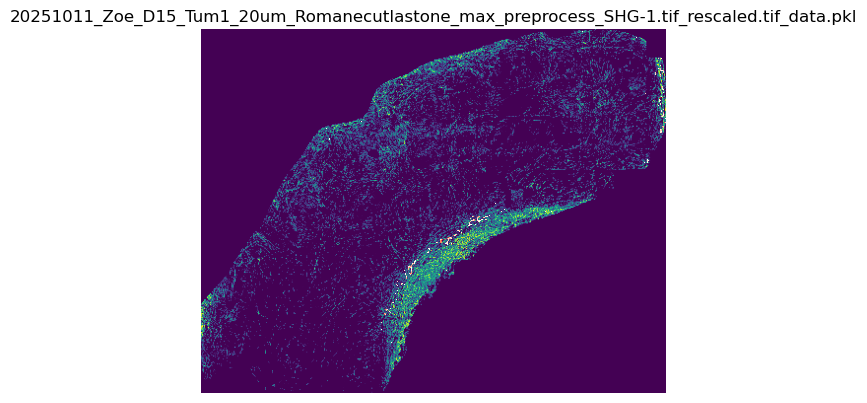

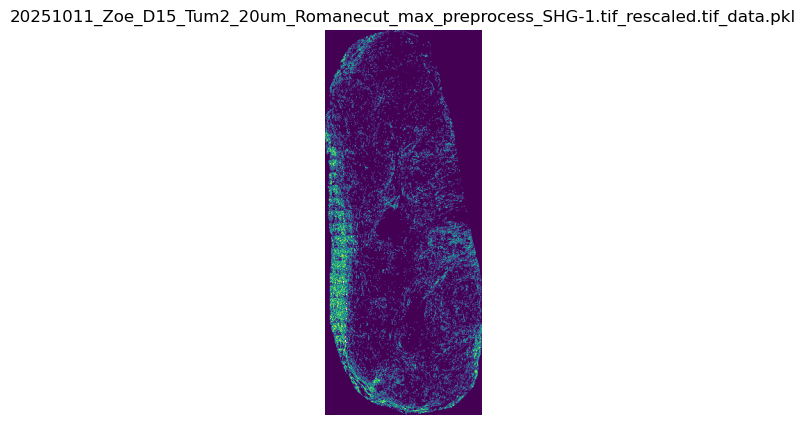

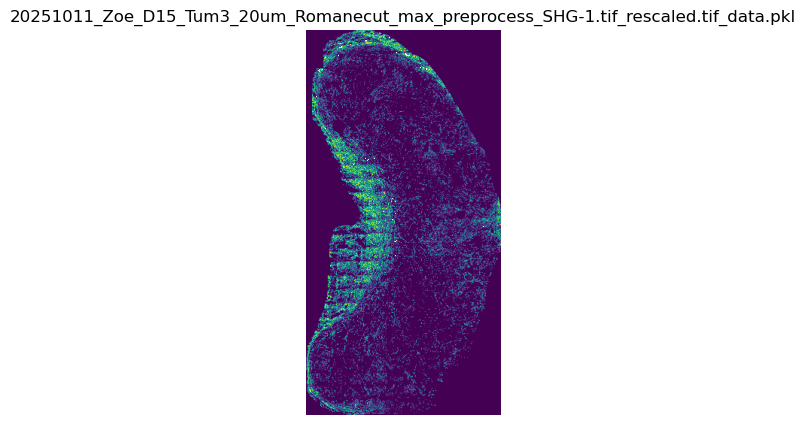

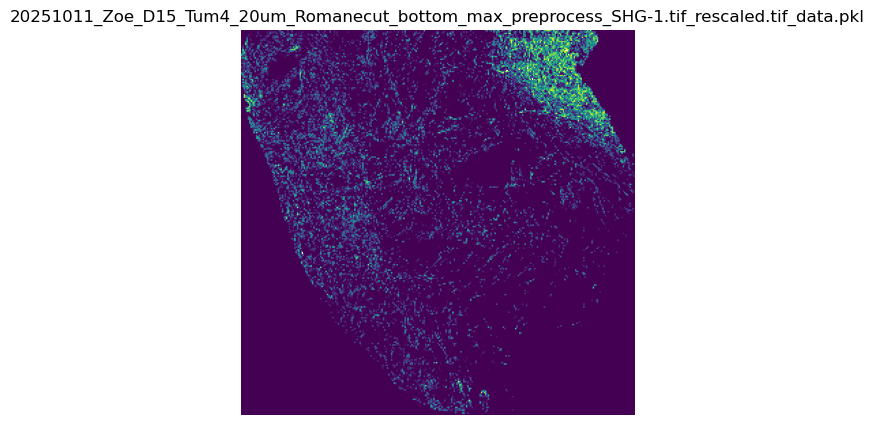

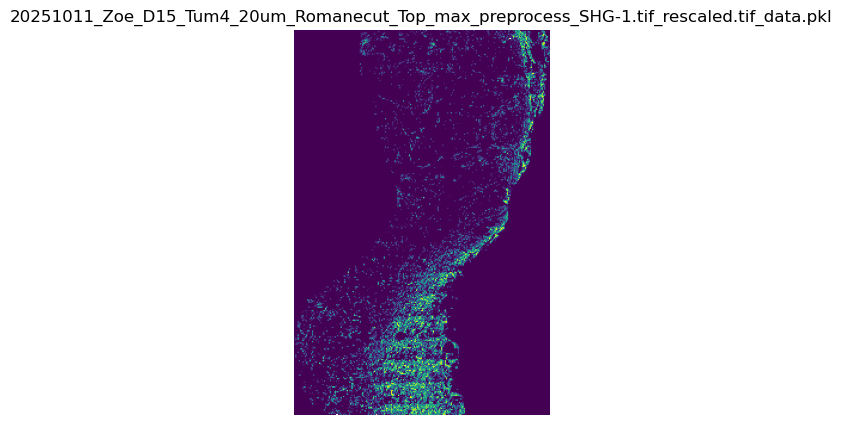

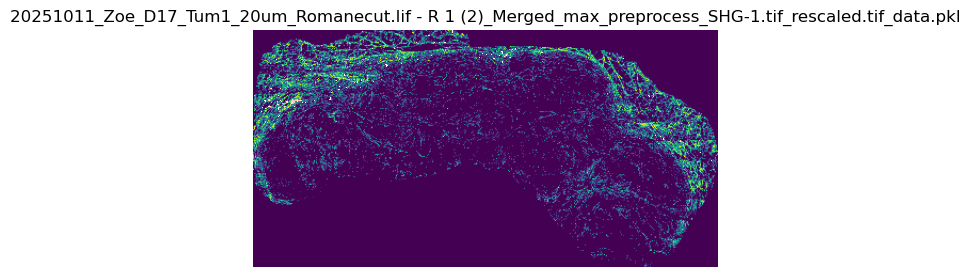

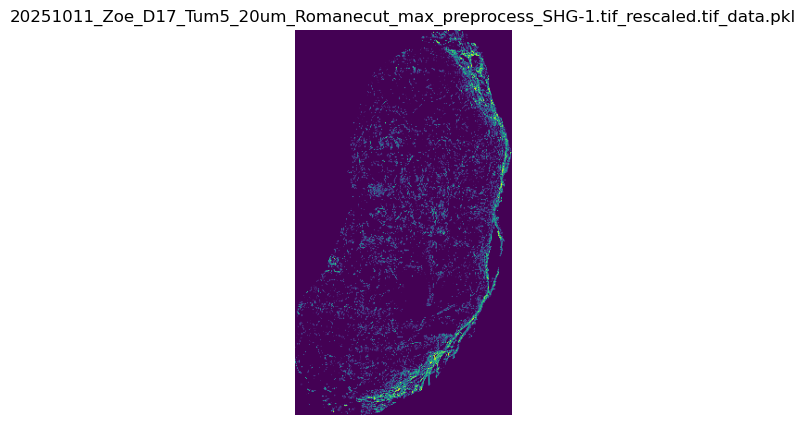

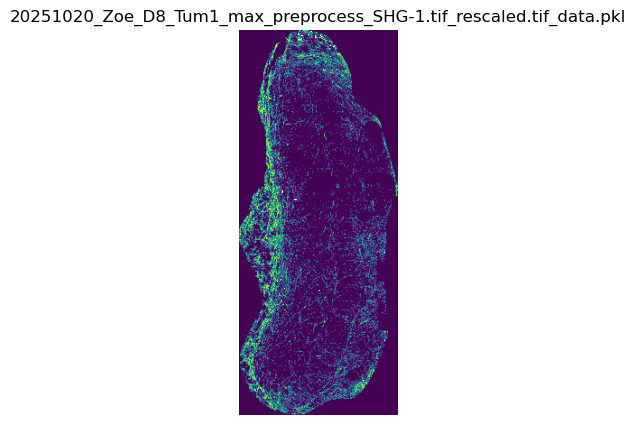

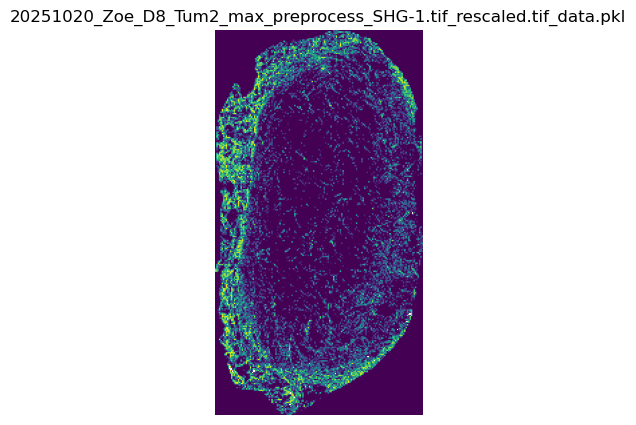

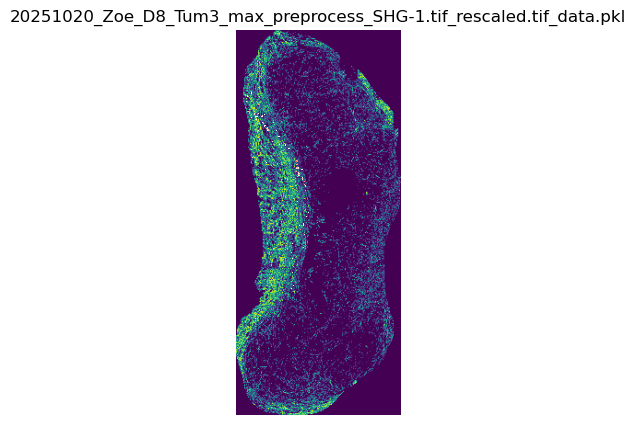

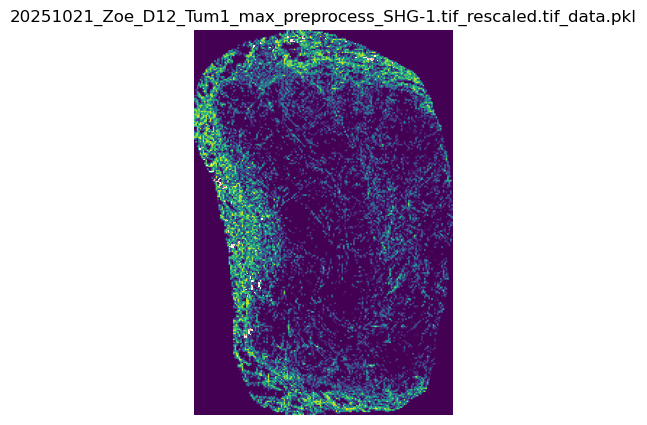

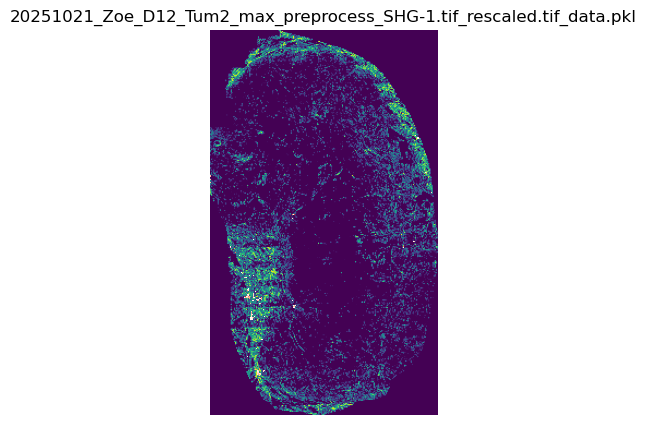

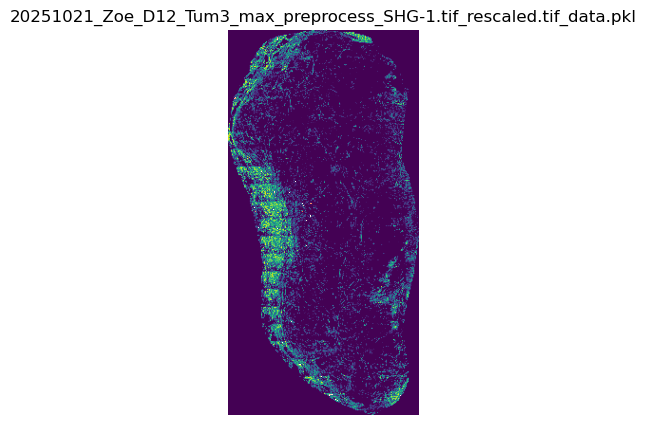

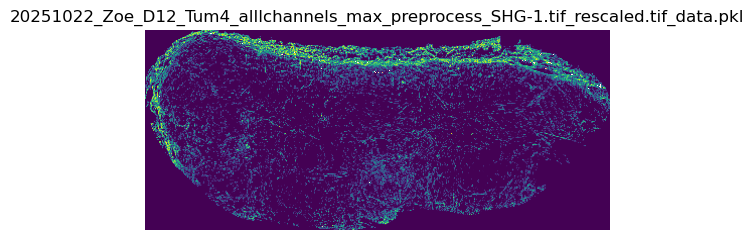

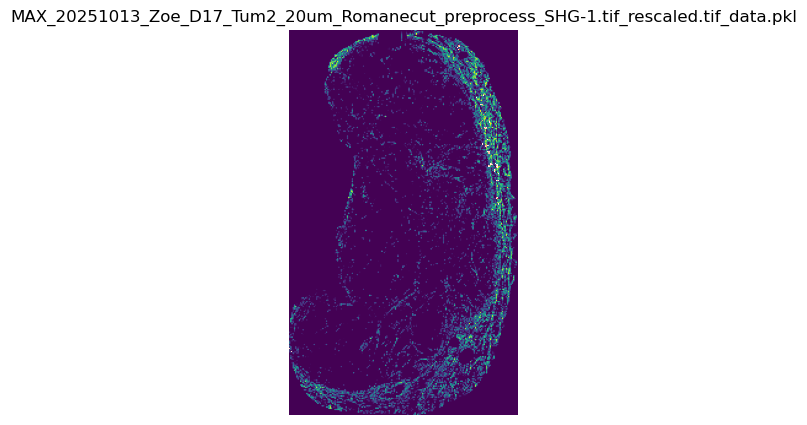

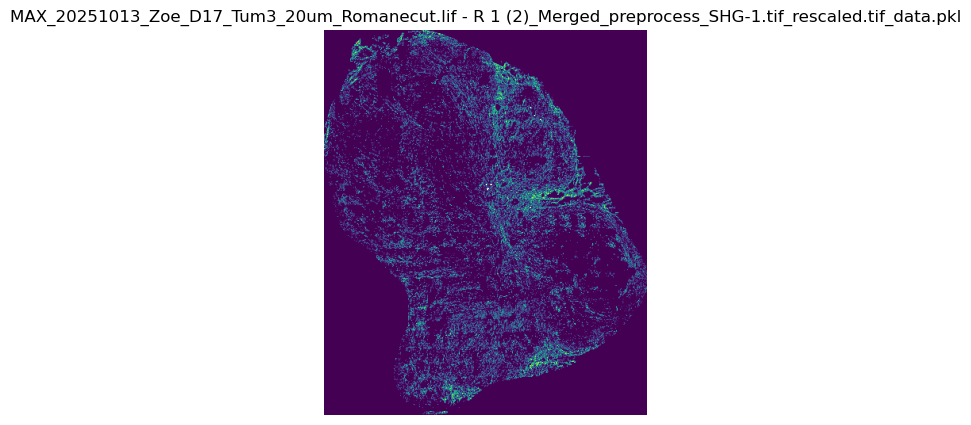

In [8]:
from src.utils import extract
import matplotlib.pyplot as plt

for i in dataframe_days["FileName"].unique():
    m = extract.extract_map(
        dataframe_days,
        "Density20",
        sample_name=i
    )
    m2 = extract.extract_map(
        dataframe_days,
        "Cells",
        sample_name=i
    )
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(m, cmap='viridis')
    ax.imshow(np.ma.masked_where(m2 <= 0, m2), cmap=plt.cm.Reds)
    ax.axis("off")
    ax.set_title(i)
    plt.savefig(results / f"{i}.png")
    plt.show()

In [9]:
# Selected features and target
features_column = FEATURES["fiber-dist-shape"]
target_column = TARGETS_COLNAMES[0]
# Best parameters
estimator_param = {
    'n_estimators': 32,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': True
}

Predicting using same timepoint

TRAIN 70%: DAY = D12 {'accuracy': [0.8101929211605651], 'balanced_accuracy': [0.7963903403643366], 'precision': [0.477540870853394], 'recall': [0.775030053237163], 'auc': [0.7963903403643368], 'mcc': [0.4999826387240195], 'f1': [0.5909581955674862]}
TEST 30%: DAY = D12 {'accuracy': [0.784575033671227], 'balanced_accuracy': [0.7424614806996681], 'precision': [0.4308103975535168], 'recall': [0.6772836538461539], 'auc': [0.7424614806996681], 'mcc': [0.4129785361274459], 'f1': [0.5266355140186916]}
TRAIN 70%: DAY = D15 {'accuracy': [0.8253086597404092], 'balanced_accuracy': [0.8195590046713846], 'precision': [0.4893989296006587], 'recall': [0.8108799454297408], 'auc': [0.8195590046713846], 'mcc': [0.5333549538612601], 'f1': [0.610397946084724]}
TEST 30%: DAY = D15 {'accuracy': [0.8035142697257974], 'balanced_accuracy': [0.7804988269554879], 'precision': [0.45041653316244795], 'recall': [0.7457559681697613], 'auc': [0.7804988269554878], 'mcc': [0.46826782492681596], 'f1': [0.561626048741510

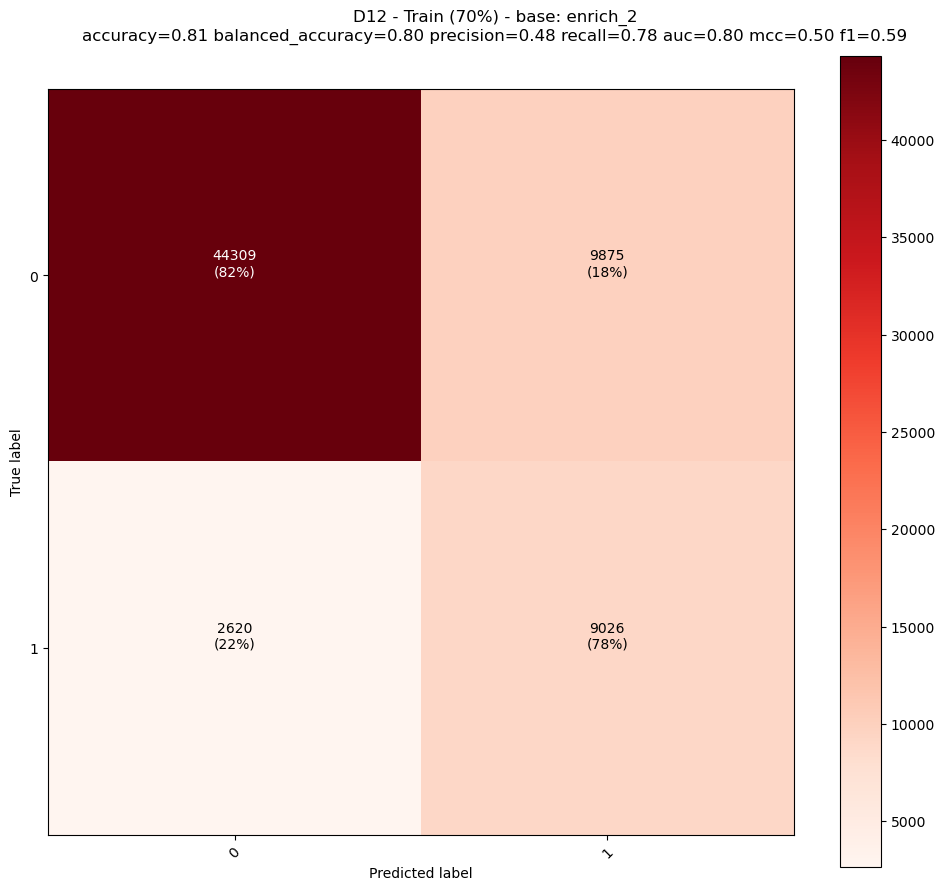

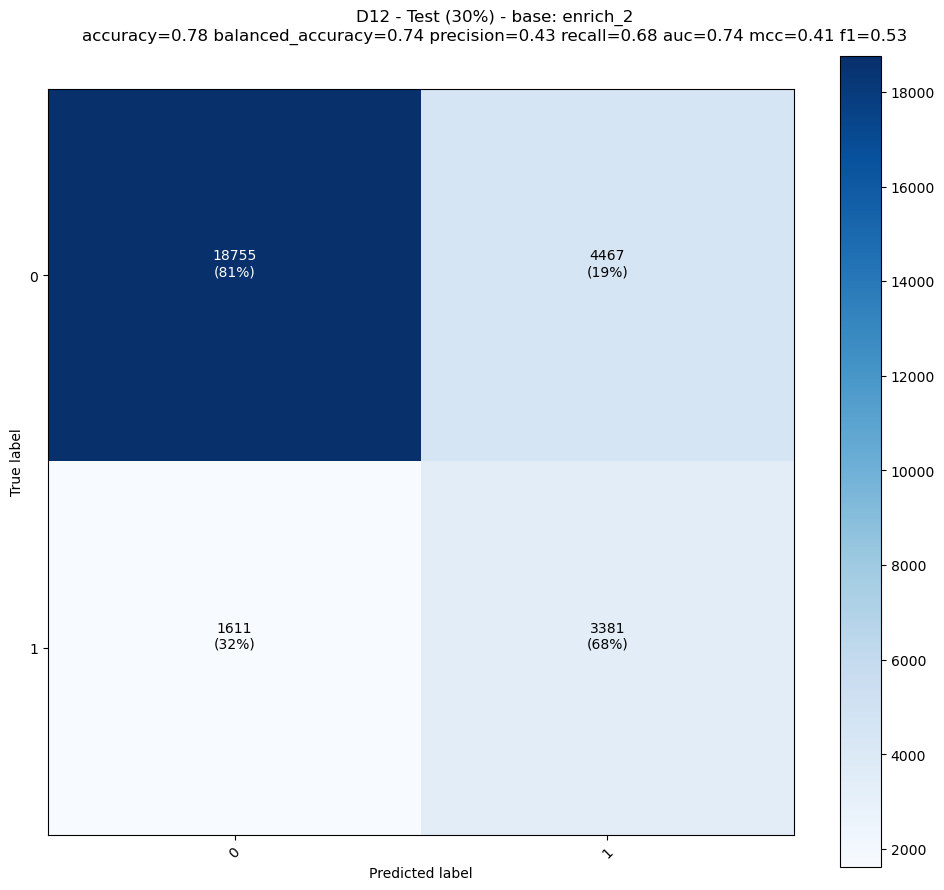

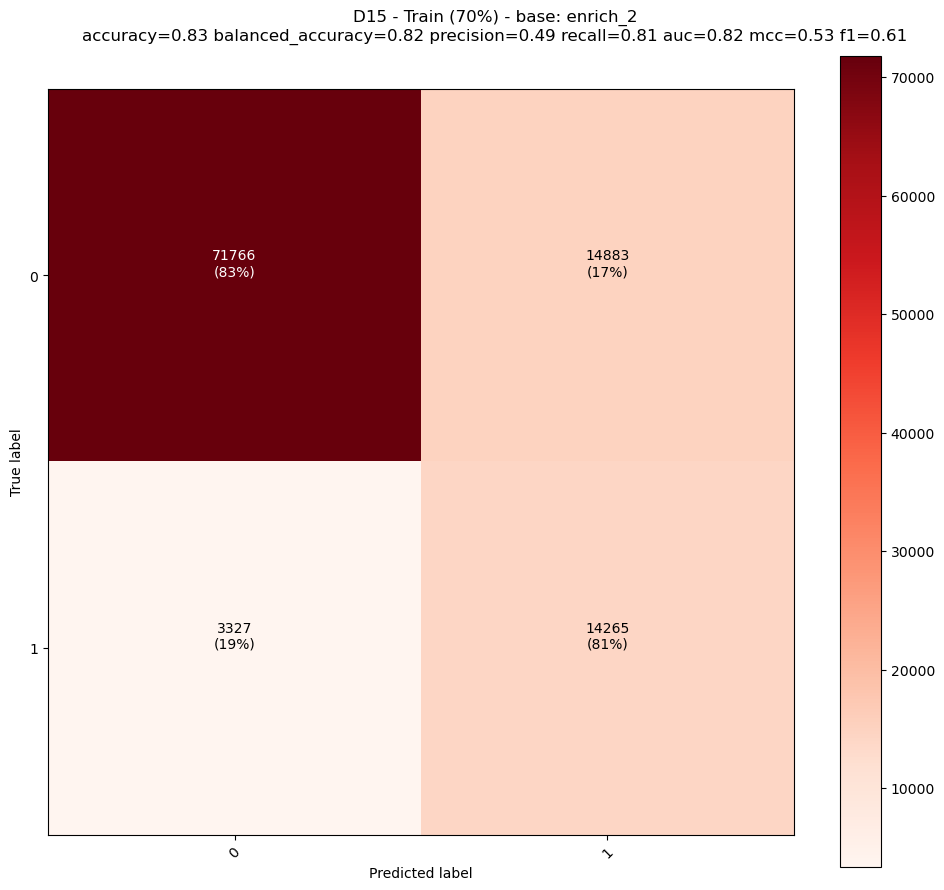

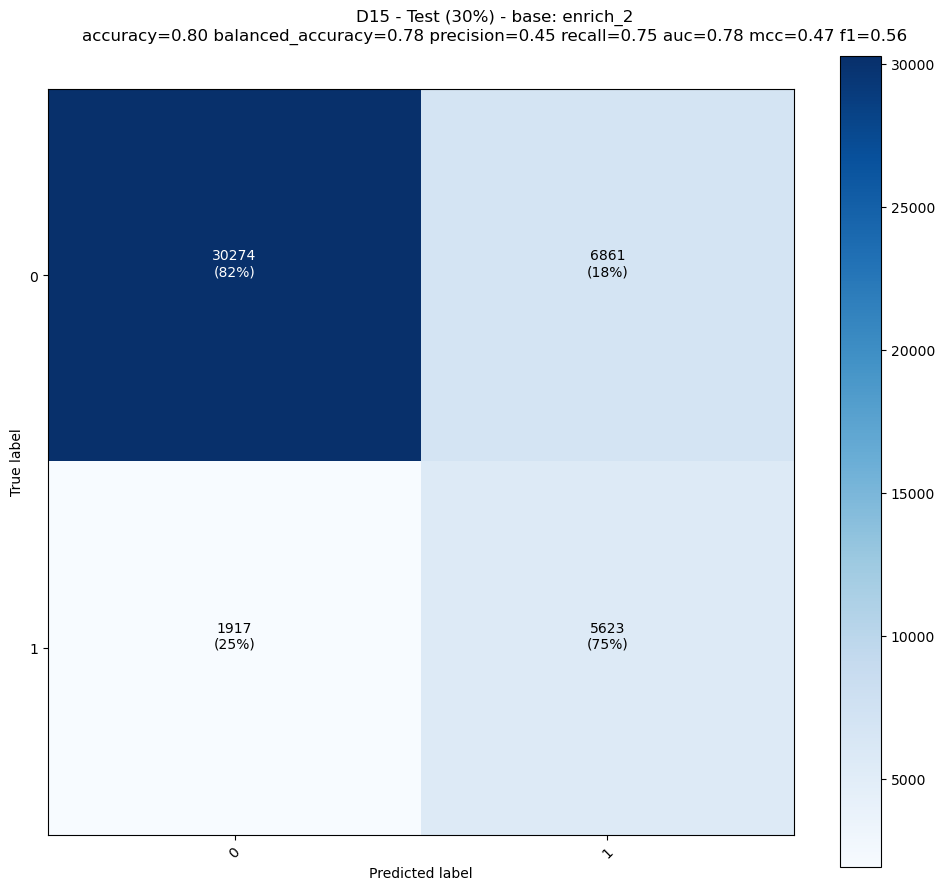

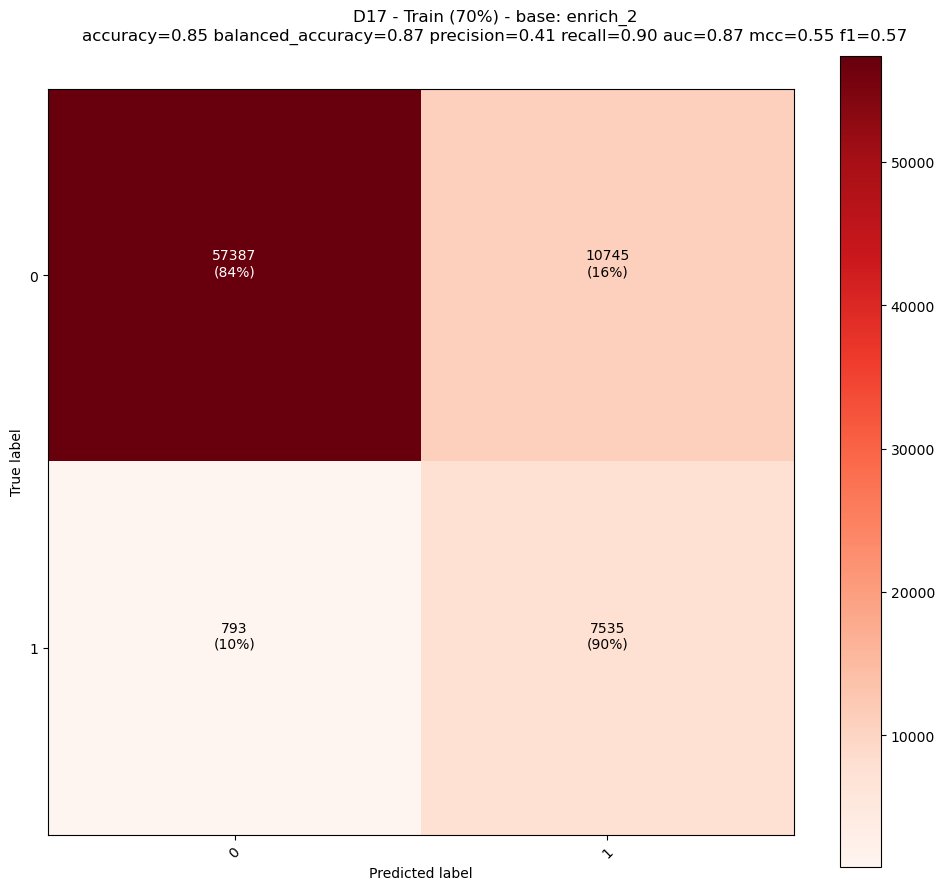

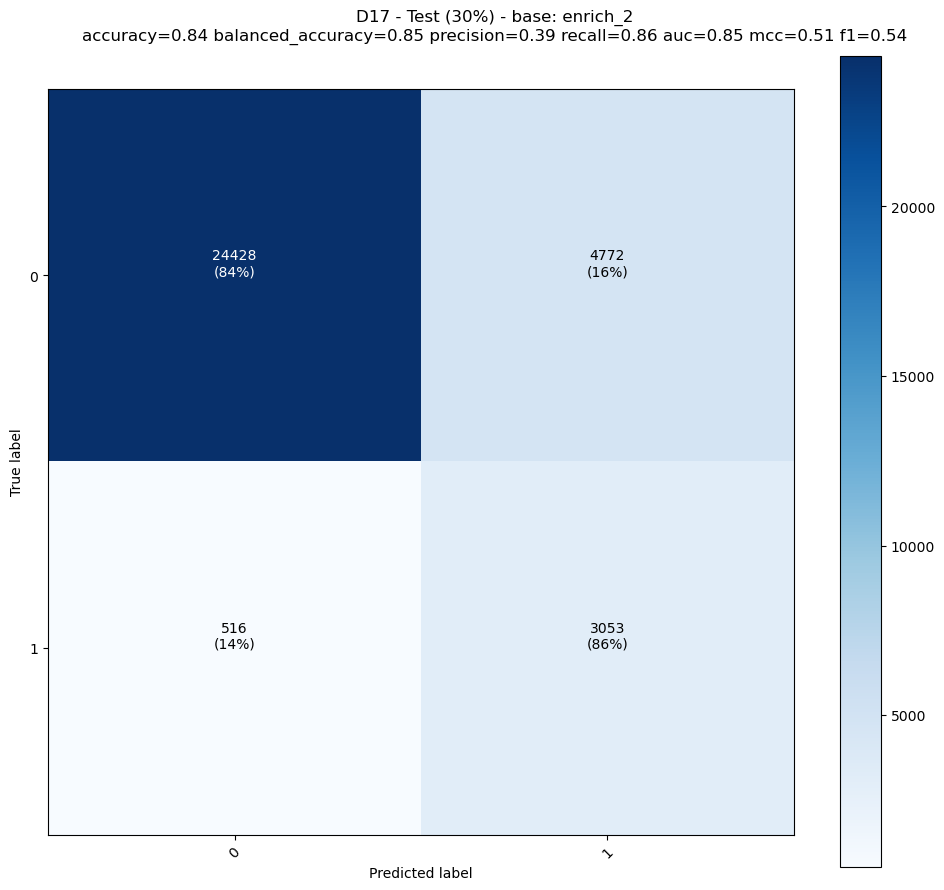

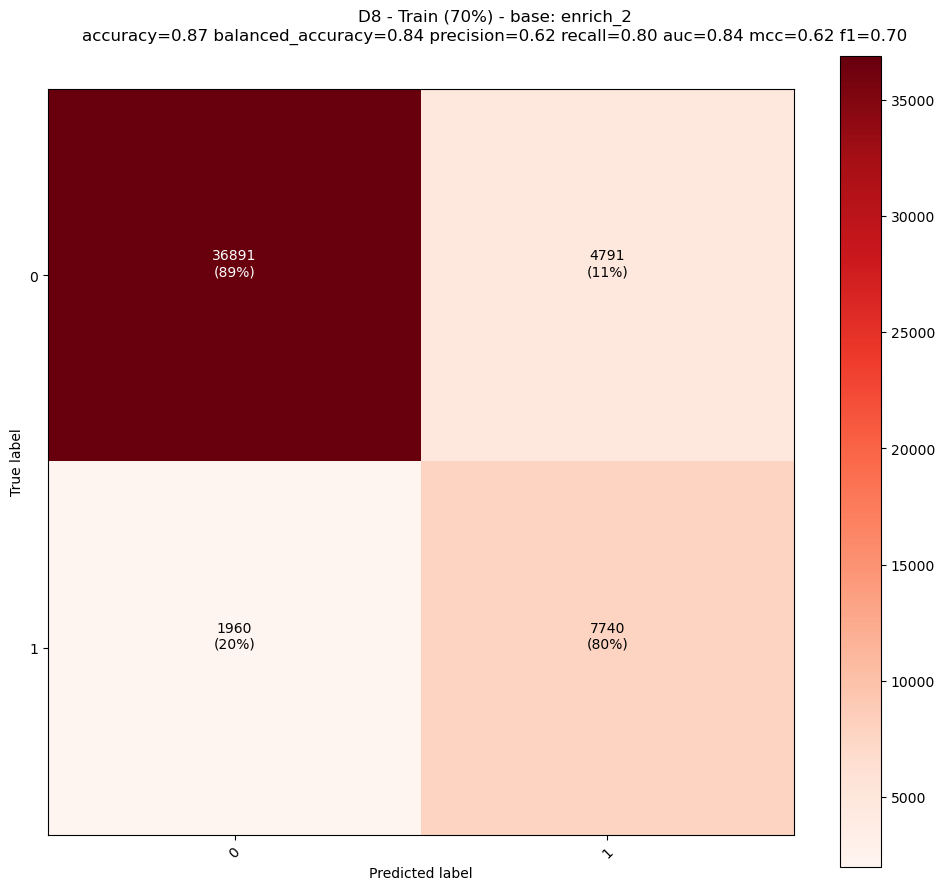

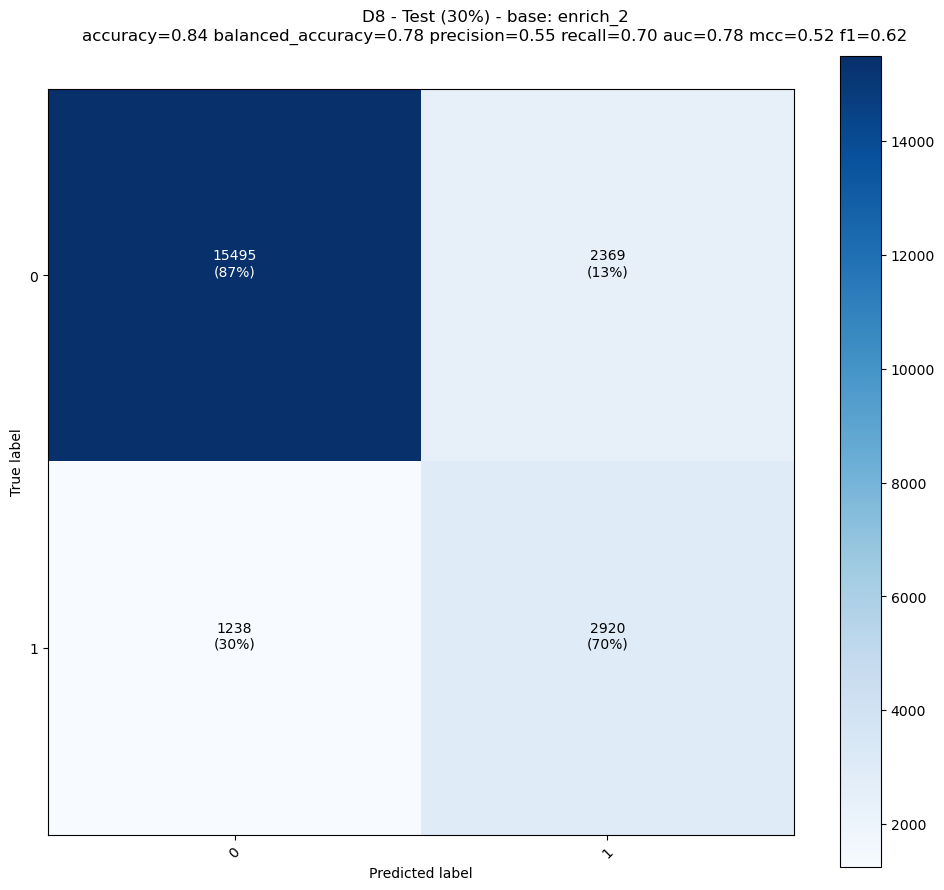

In [10]:
#
time_tt_self_dir = time_tt_dir / "self"
time_tt_self_dir.mkdir(parents=True, exist_ok=True)

scores_t = dict()
for condition_name, obs in dataframe_days.reset_index().groupby("TimeCondition"):
    # To Pred
    x_t, y_t, groups_t = models.split_xy(
        df=obs, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
    )
    x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(
        x_t, y_t, test_size=TEST_SIZE, random_state=SEED, stratify=obs["enrich_2"]
    )
    estimator_t = RandomForestClassifier(**estimator_param, random_state=SEED)
    estimator_t.fit(x_t_train, y_t_train.ravel())
    obs_train, pred_train = models.predict_model(x_t_train, y_t_train, estimator_t)
    obs_test, pred_test = models.predict_model(x_t_test, y_t_test, estimator_t)
    # Metrics
    scores_t_train = models.scorer_model(
        estimator=estimator_t, x=x_t_train, y=y_t_train, scorer=SCORING_base
    )
    scores_t_test = models.scorer_model(
        estimator=estimator_t, x=x_t_test, y=y_t_test, scorer=SCORING_base
    )
    scores_t[condition_name] = pd.DataFrame(index=SCORING_base.keys())
    scores_t[condition_name]["train"] = [v[0] for v in scores_t_train.values()]
    scores_t[condition_name]["test"] = [v[0] for v in scores_t_test.values()]
    score_t_train_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_train.items()])
    score_t_test_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_test.items()])
    print("TRAIN 70%: DAY =", condition_name, scores_t_train)
    print("TEST 30%: DAY =", condition_name, scores_t_test)
    scores_t[condition_name].to_csv(time_tt_self_dir / f"{condition_name}_performances.csv")
    #
    _, _, cf_matrix, cf_matrix_norm = display.display_confusion_matrix(
        observed=y_t_train, predicted=pred_train, cmap="Reds",
        labels=None, filepath=time_tt_self_dir / f"{condition_name}_{1-TEST_SIZE}_confusion_matrix_on_train.png",
        title=f"{condition_name} - Train (70%) - base: {target_column}\n{score_t_train_print}",
        add_cf_matrix=True
    )
    pd.DataFrame({"true": y_t_train.reshape(-1), "pred": pred_train.reshape(-1), "label": "train"}).to_csv(time_tt_self_dir / f"{condition_name}_{1-TEST_SIZE}_labels_train.csv")
    pd.DataFrame(cf_matrix).to_csv(time_tt_self_dir / f"{condition_name}_{1-TEST_SIZE}_confusion_matrix_on_train.csv")
    pd.DataFrame(cf_matrix_norm).to_csv(time_tt_self_dir / f"{condition_name}_{1-TEST_SIZE}_confusion_matrix-norm_on_train.csv")
    #
    _, _, cf_matrix, cf_matrix_norm = display.display_confusion_matrix(
        observed=y_t_test, predicted=pred_test, cmap="Blues",
        labels=None, filepath=time_tt_self_dir / f"{condition_name}_{TEST_SIZE}_confusion_matrix_on_test.png",
        title=f"{condition_name} - Test (30%) - base: {target_column}\n{score_t_test_print}",
        add_cf_matrix=True
    )
    pd.DataFrame({"true": y_t_test.reshape(-1), "pred": pred_test.reshape(-1), "label": "test"}).to_csv(time_tt_self_dir / f"{condition_name}_{TEST_SIZE}_labels_test.csv")
    pd.DataFrame(cf_matrix).to_csv(time_tt_self_dir / f"{condition_name}_{TEST_SIZE}_confusion_matrix_on_test.csv")
    pd.DataFrame(cf_matrix_norm).to_csv(time_tt_self_dir / f"{condition_name}_{TEST_SIZE}_confusion_matrix-norm_on_test.csv")
    #

Train on time and predict on another/same time

Train on D8 pred on D8/ accuracy=0.85 balanced_accuracy=0.83 precision=0.58 recall=0.79 auc=0.83 mcc=0.59 f1=0.67
Train on D8 pred on D12/ accuracy=0.72 balanced_accuracy=0.54 precision=0.23 recall=0.26 auc=0.54 mcc=0.07 f1=0.25
Train on D8 pred on D15/ accuracy=0.75 balanced_accuracy=0.53 precision=0.22 recall=0.19 auc=0.53 mcc=0.06 f1=0.21
Train on D8 pred on D17/ accuracy=0.83 balanced_accuracy=0.56 precision=0.22 recall=0.21 auc=0.56 mcc=0.12 f1=0.22
Train on D12 pred on D8/ accuracy=0.77 balanced_accuracy=0.53 precision=0.27 recall=0.15 auc=0.53 mcc=0.07 f1=0.19
Train on D12 pred on D12/ accuracy=0.81 balanced_accuracy=0.79 precision=0.47 recall=0.77 auc=0.79 mcc=0.49 f1=0.59
Train on D12 pred on D15/ accuracy=0.77 balanced_accuracy=0.55 precision=0.27 recall=0.23 auc=0.55 mcc=0.11 f1=0.25
Train on D12 pred on D17/ accuracy=0.86 balanced_accuracy=0.57 precision=0.29 recall=0.20 auc=0.57 mcc=0.17 f1=0.24
Train on D15 pred on D8/ accuracy=0.73 balanced_accuracy=0.54 precision=0.26 r

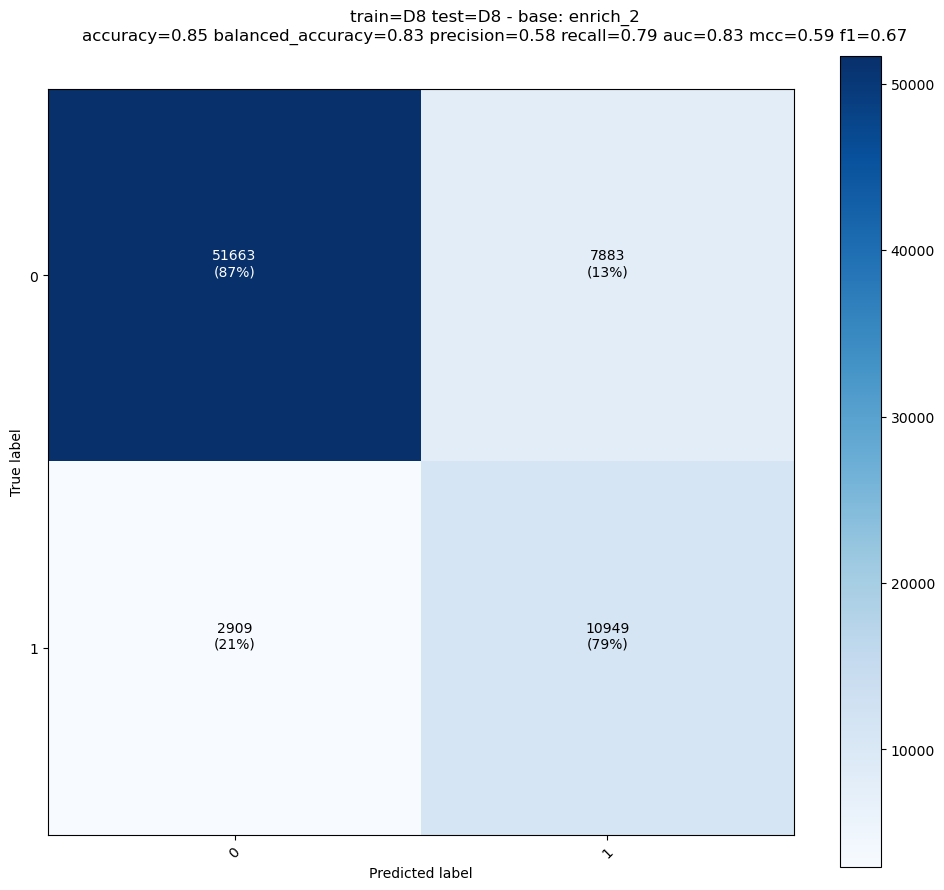

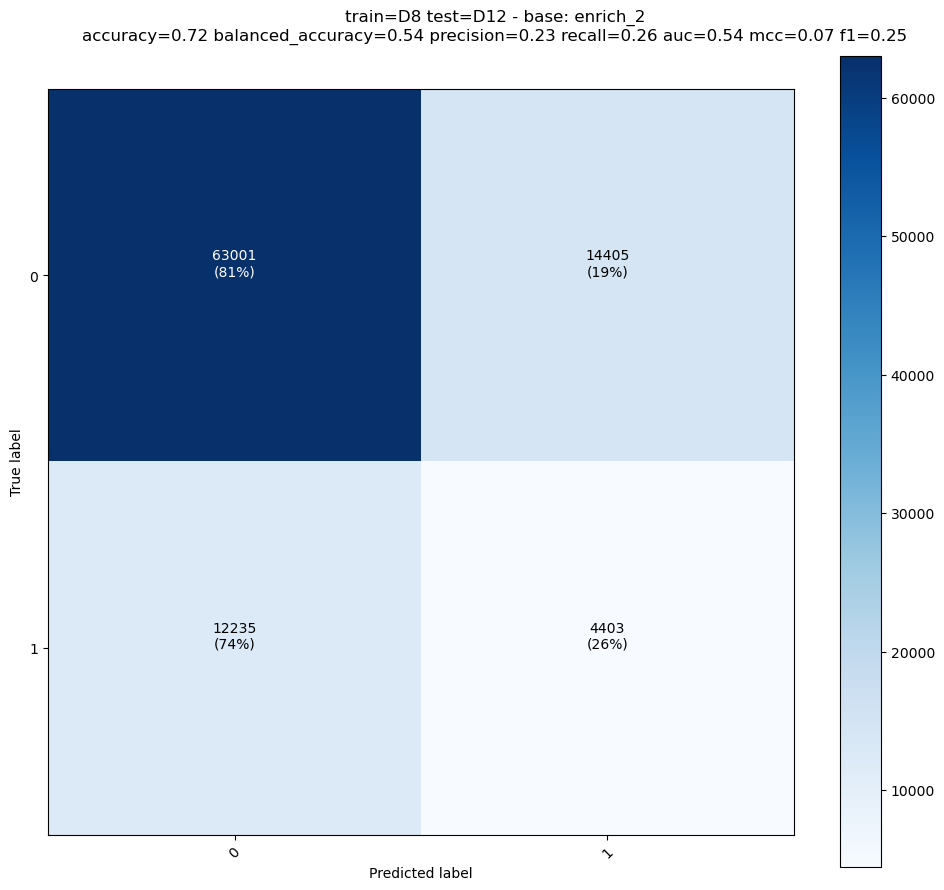

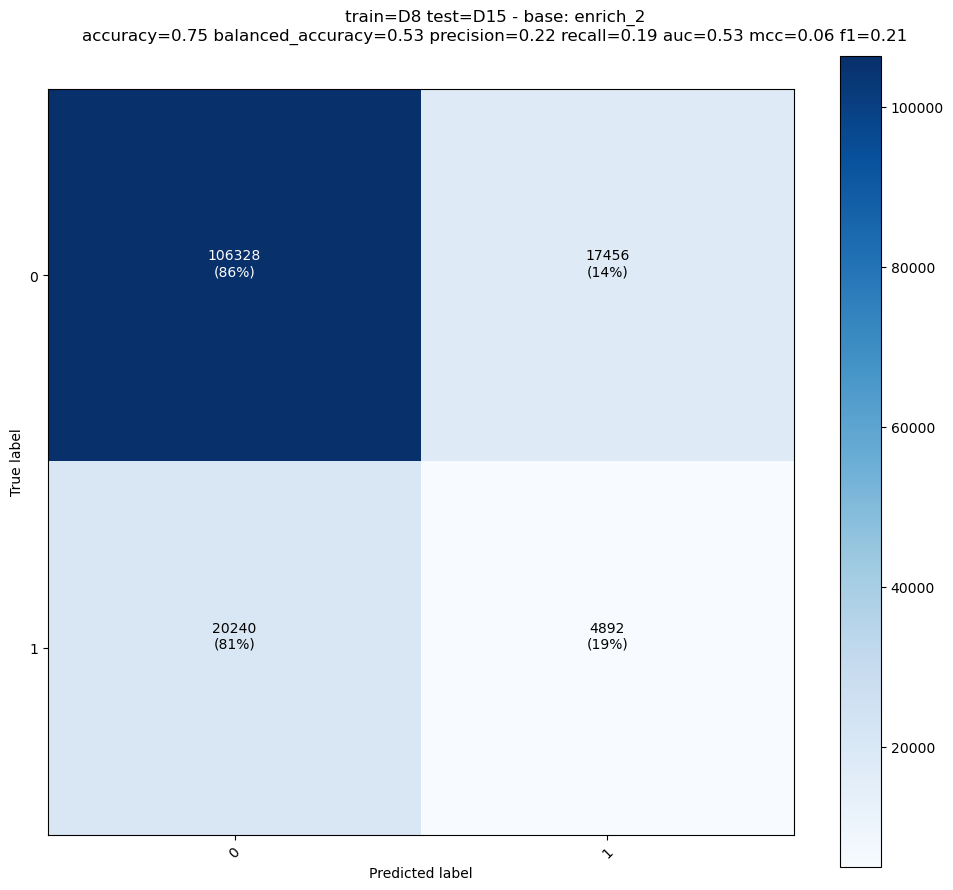

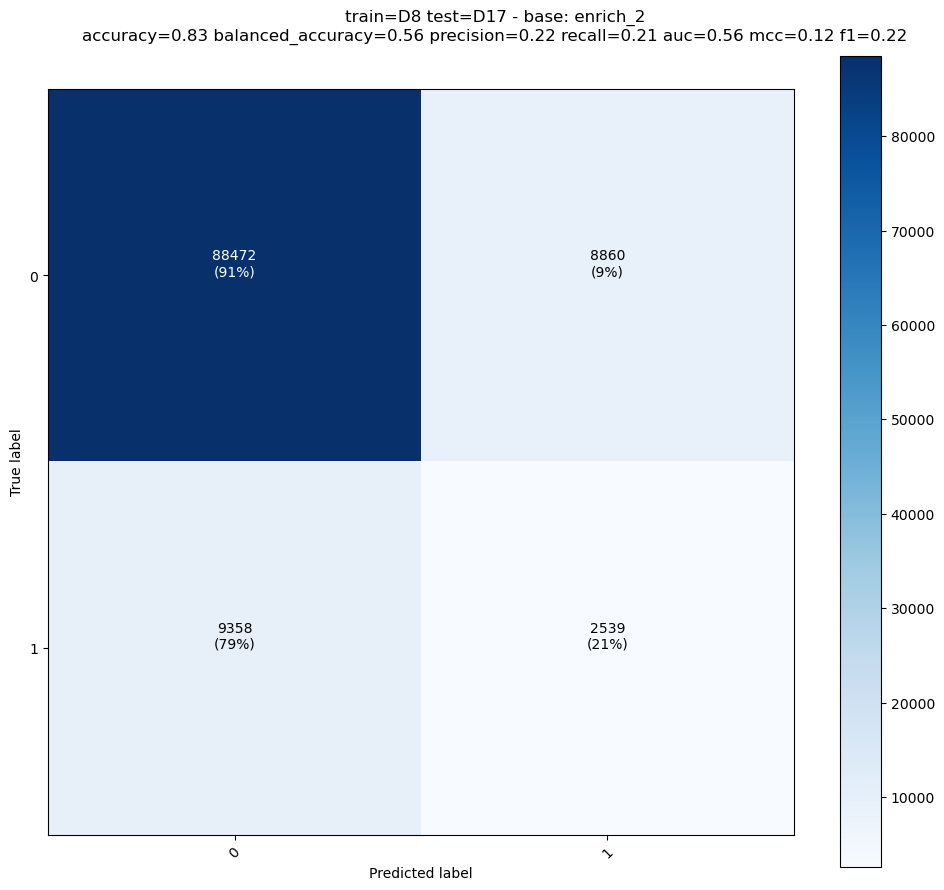

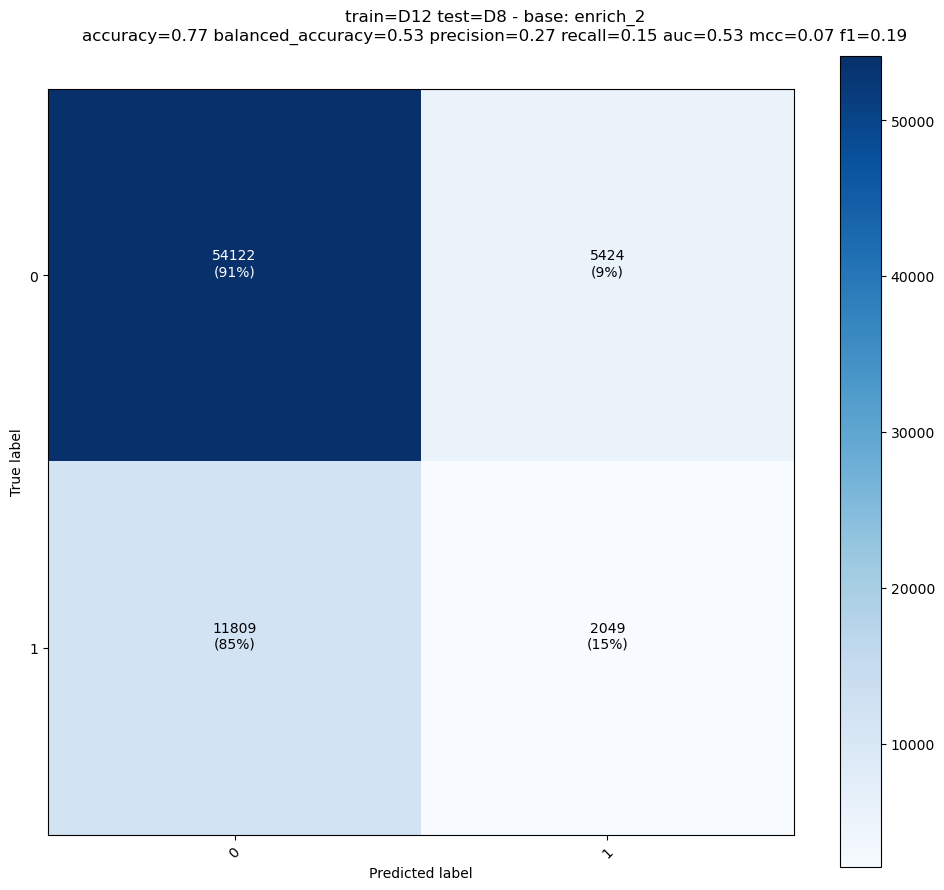

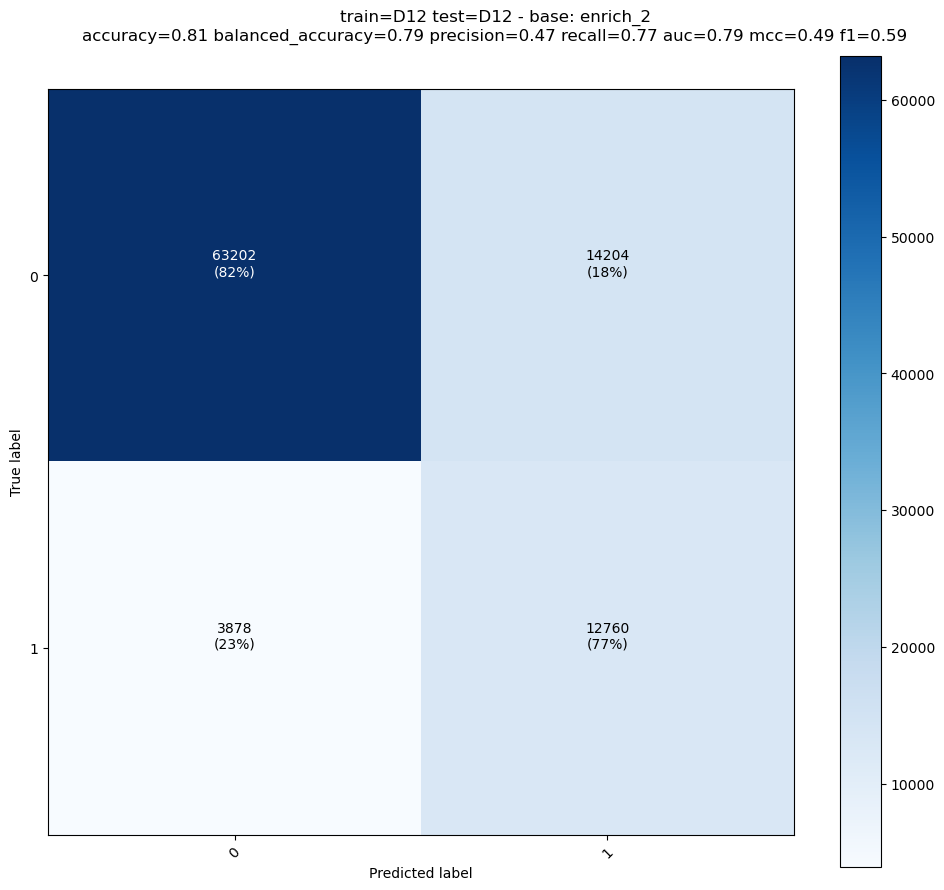

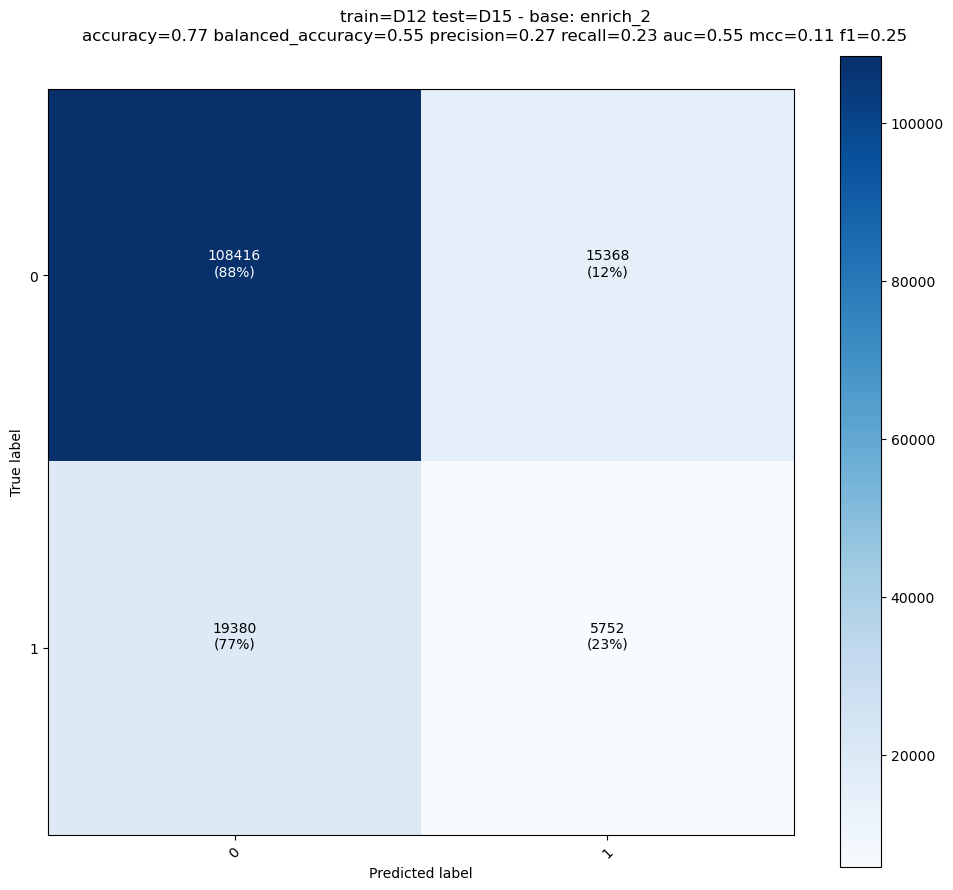

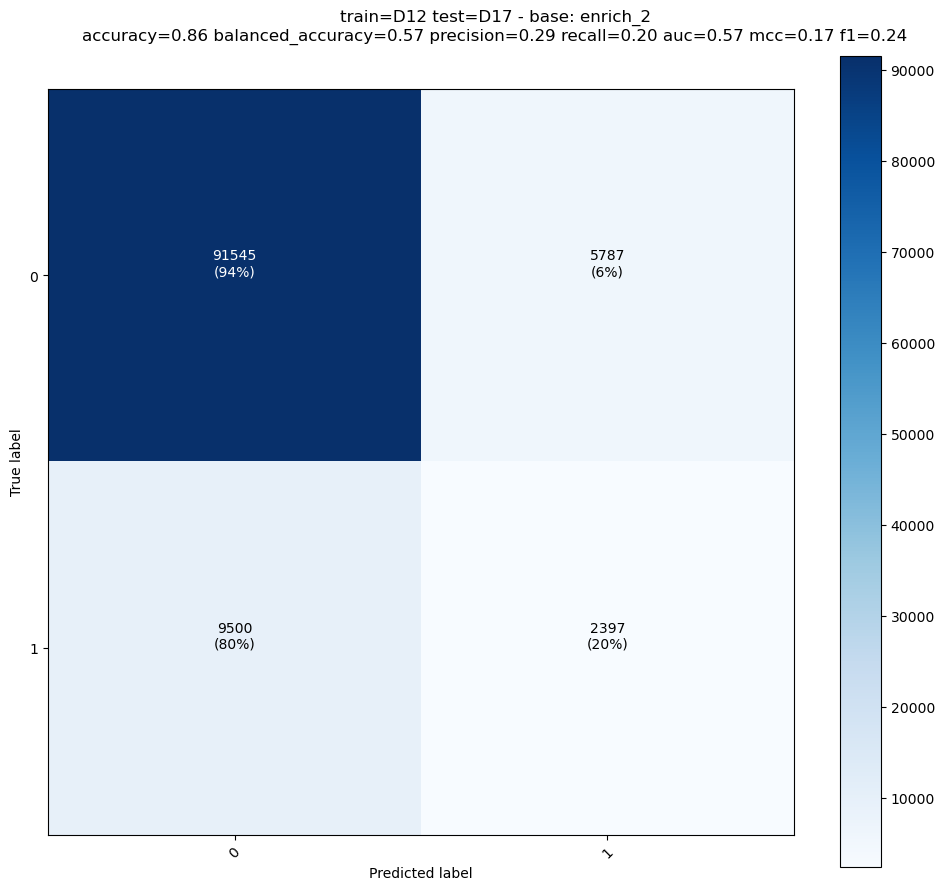

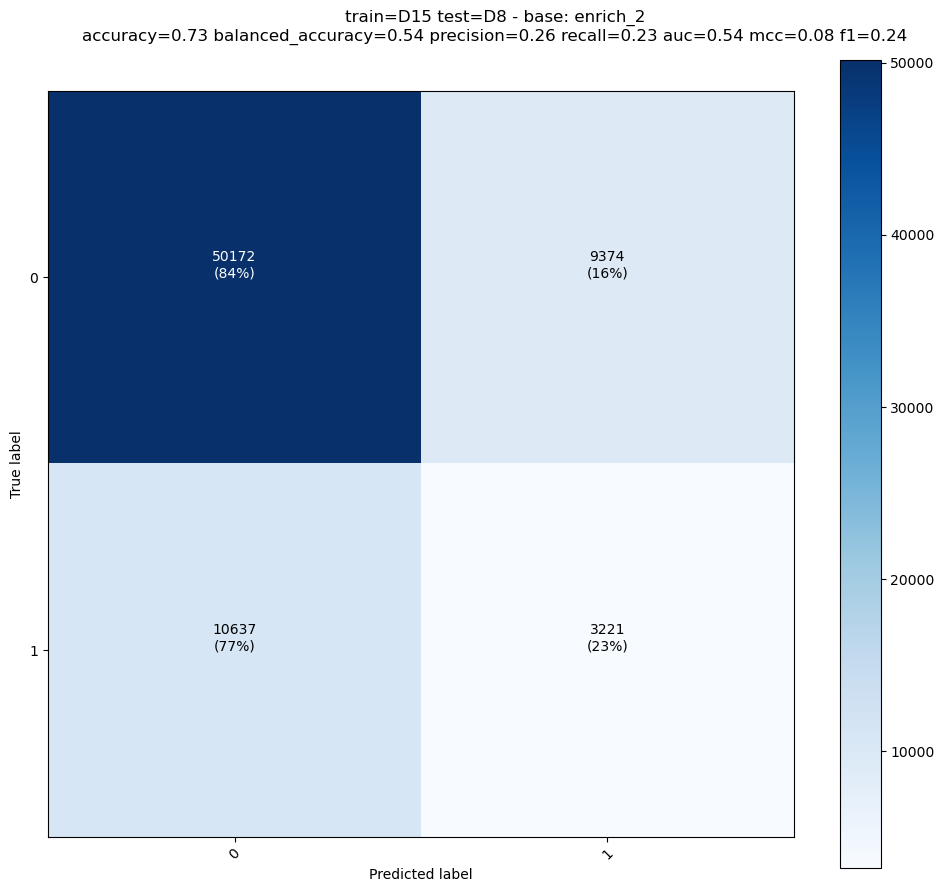

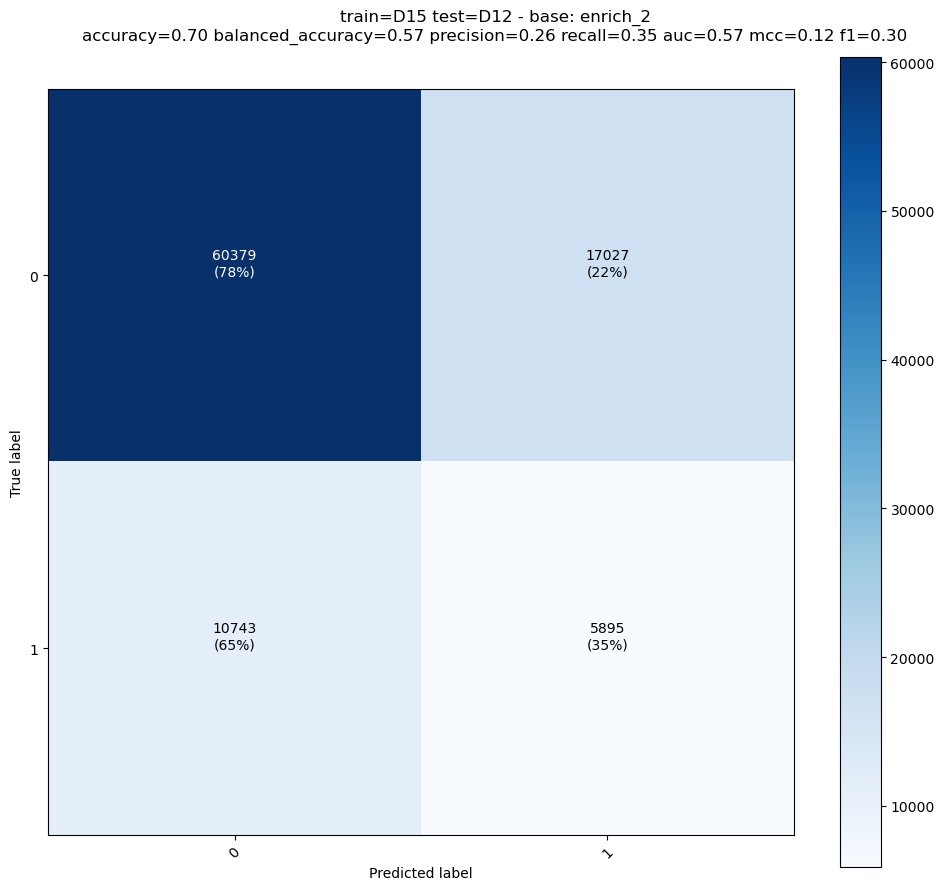

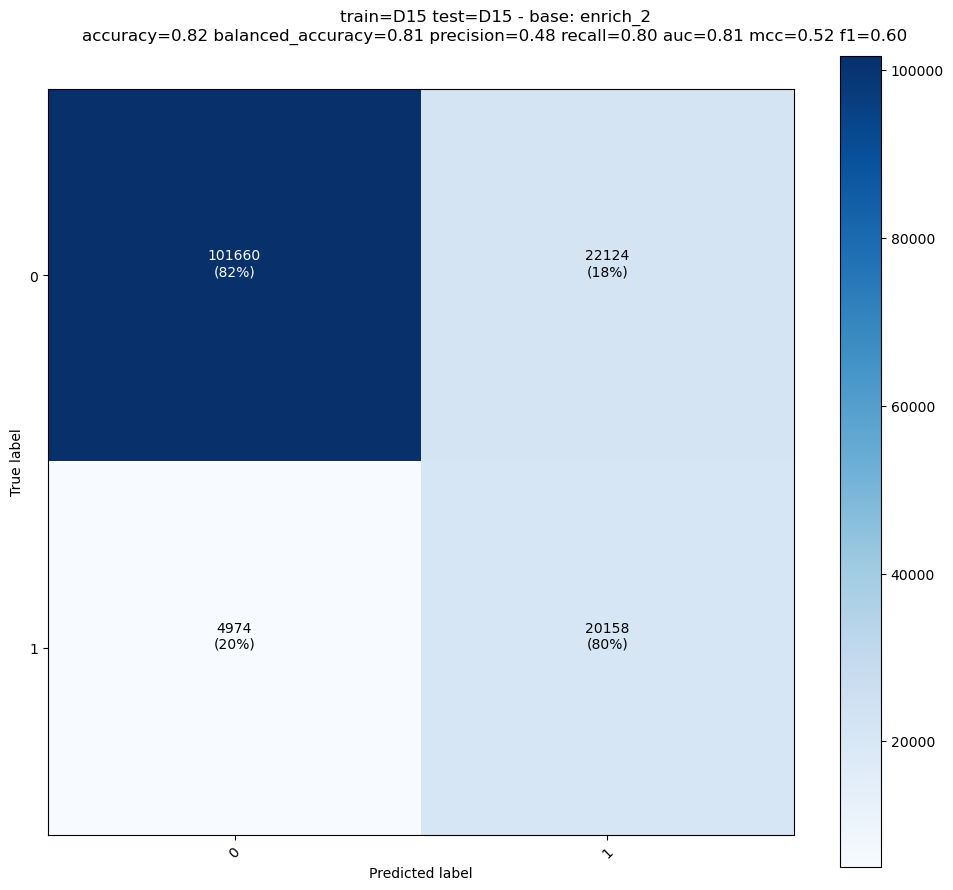

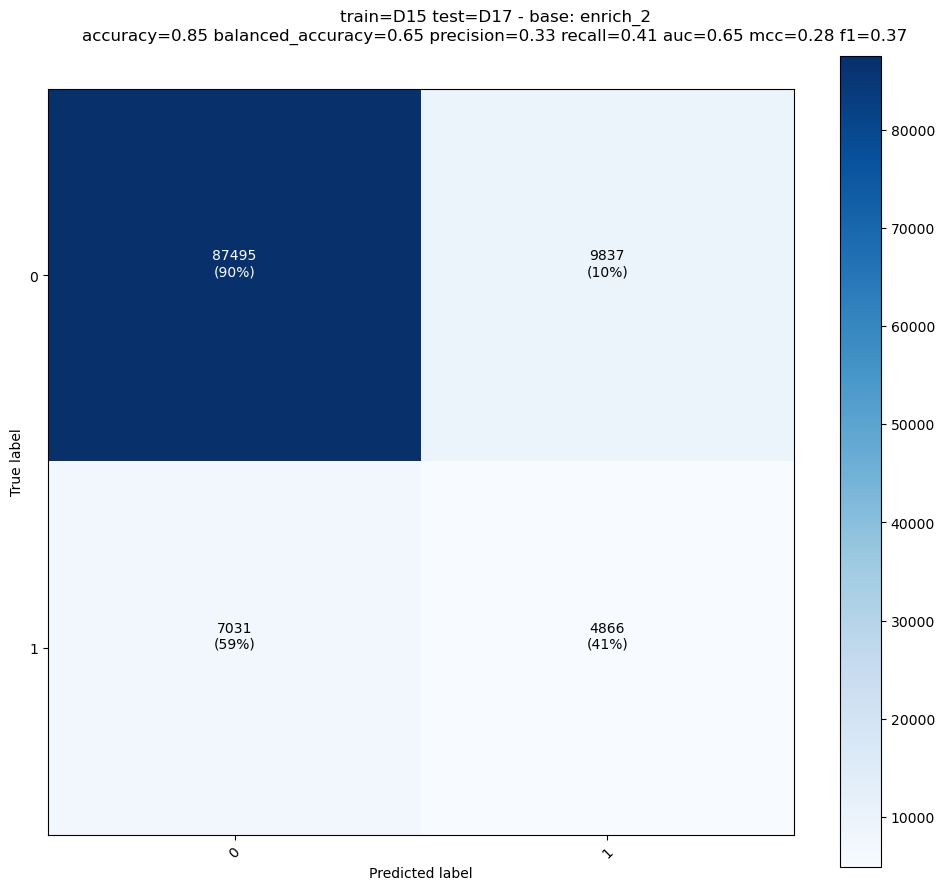

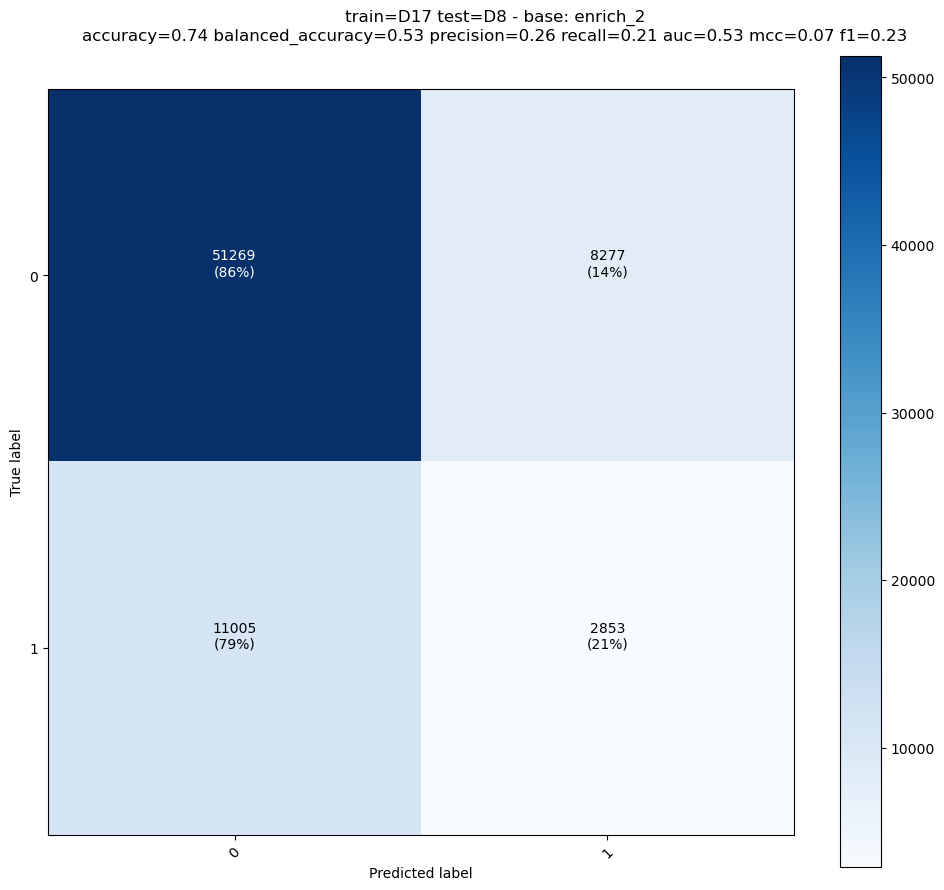

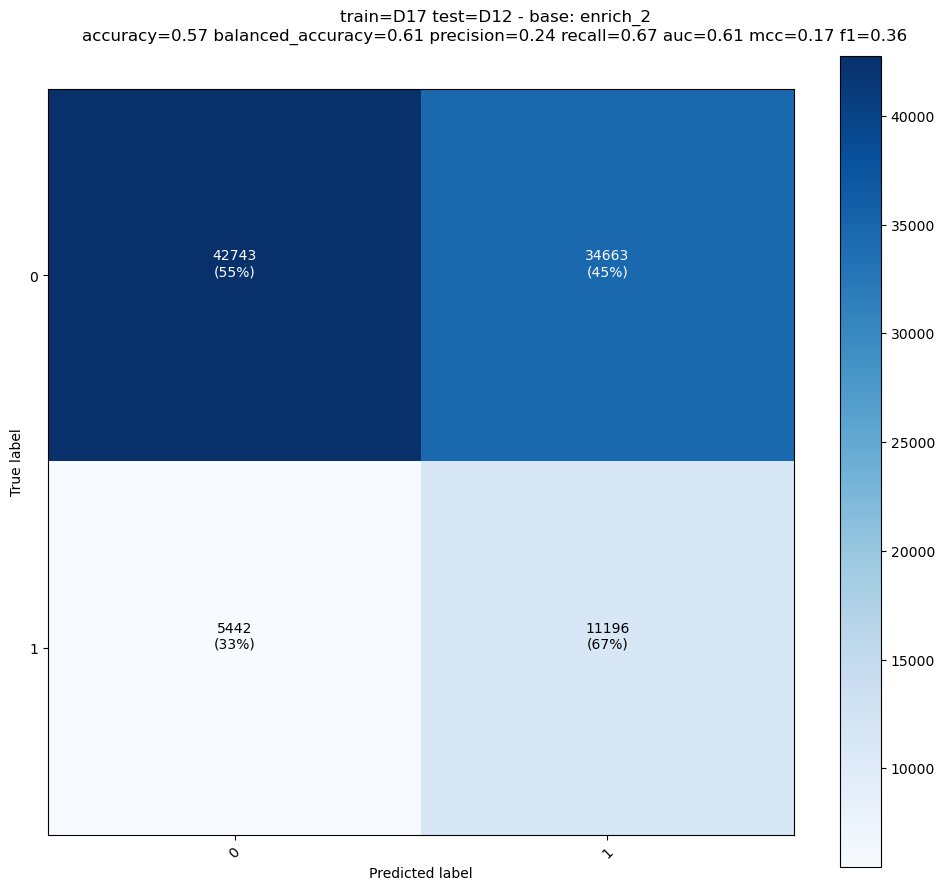

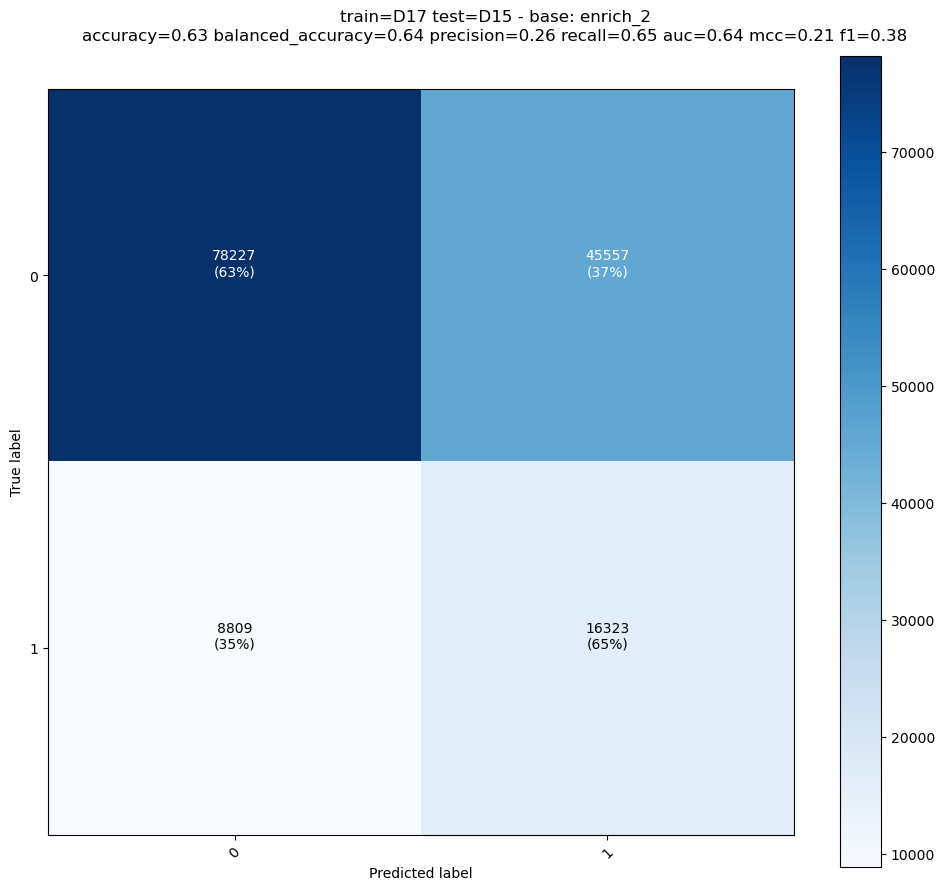

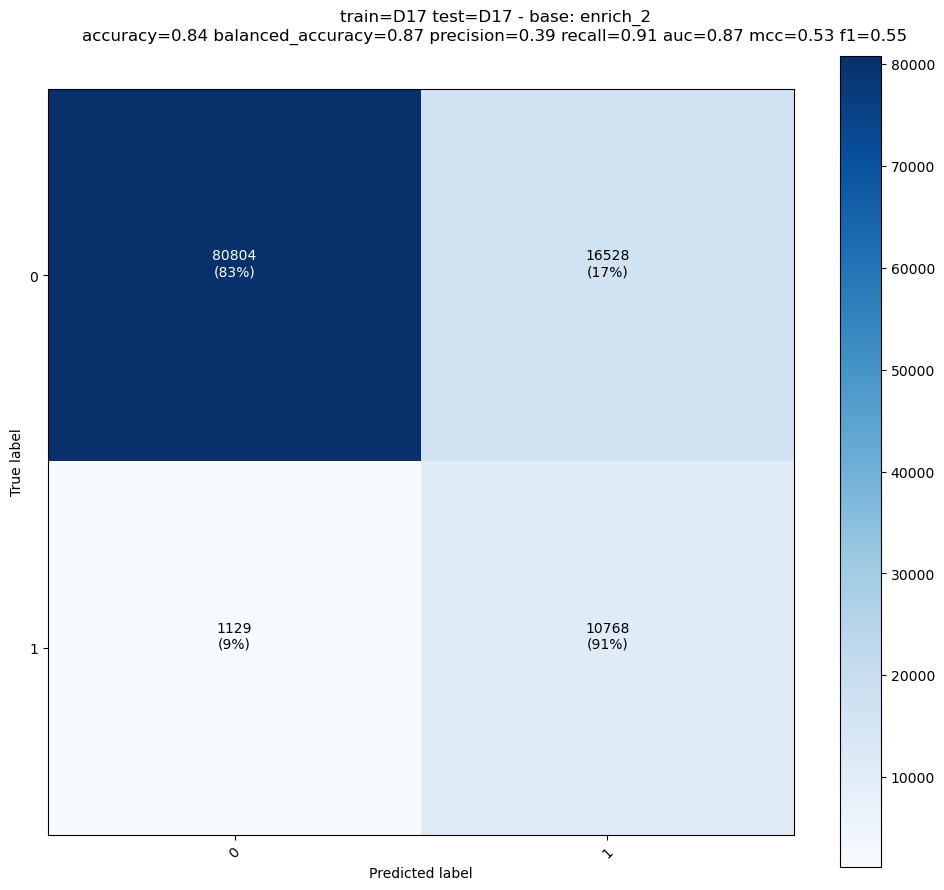

In [12]:
#
time_tt_other_dir = time_tt_dir / "vs_all"
time_tt_other_dir.mkdir(parents=True, exist_ok=True)

timepoints = ["D8", "D12", "D15", "D17"]
perf_per_time = {t: pd.DataFrame(index=SCORING_base.keys()) for t in timepoints}
models_t = dict()
for condition_name in timepoints:
    # Train on selected timepoint
    df_t_actual = dataframe_days[dataframe_days["TimeCondition"] == condition_name]
    x_t_actual, y_t_actual, groups_t_actual = models.split_xy(
        df=df_t_actual, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
    )
    estimator_t_actual = RandomForestClassifier(**estimator_param, random_state=SEED)
    models_t[condition_name] = estimator_t_actual.fit(x_t_actual, y_t_actual.ravel())
    # Predict on other timepoint
    for to_pred_timepoint in timepoints:
        df_t_topred = dataframe_days[dataframe_days["TimeCondition"] == to_pred_timepoint]
        x_t_topred, y_t_topred, groups_t_topred = models.split_xy(
            df=df_t_topred, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
        )
        obs_t_topred, pred_t_topred = models.predict_model(x_t_topred, y_t_topred, estimator_t_actual)
        # Metrics
        scores_t_topred = models.scorer_model(
            estimator=estimator_t_actual, x=x_t_topred, y=y_t_topred, scorer=SCORING_base
        )
        score_t_print = " ".join([f"{k}={v[0]:.2f}" for k, v in scores_t_topred.items()])
        print(f"Train on {condition_name} pred on {to_pred_timepoint}/", score_t_print)
        #
        _, _, cf_matrix, cf_matrix_norm = display.display_confusion_matrix(
            observed=y_t_topred, predicted=pred_t_topred, cmap="Blues",
            labels=None, filepath=time_tt_other_dir / f"{condition_name}_to_{to_pred_timepoint}_confusion_matrix.png",
            title=f"train={condition_name} test={to_pred_timepoint} - base: {target_column}\n{score_t_print}",
            add_cf_matrix=True
        )
        pd.DataFrame({"true": y_t_topred.reshape(-1), "pred": pred_t_topred.reshape(-1), "label": "test"}).to_csv(time_tt_other_dir / f"{condition_name}_to_{to_pred_timepoint}_labels.csv")
        pd.DataFrame(cf_matrix).to_csv(time_tt_other_dir / f"{condition_name}_to_{to_pred_timepoint}_confusion_matrix.csv")
        pd.DataFrame(cf_matrix_norm).to_csv(time_tt_other_dir / f"{condition_name}_to_{to_pred_timepoint}_confusion_matrix-norm.csv")
        #
        perf_per_time[condition_name][to_pred_timepoint] = [v[0] for k, v in scores_t_topred.items()]
    perf_per_time[condition_name].to_csv(time_tt_other_dir / f"{condition_name}_to_others.csv")